In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re

from collections import defaultdict

In [2]:
# Path to the folder containing the inputs in the secCellFie repository
folder = './secCellFie-master/CellFie/input/'

# Metabolic reconstruction

In [3]:
from cobra.io import load_matlab_model

In [4]:
model = scipy.io.loadmat(folder + '/MT_iMM1415_sec.mat')['model']

In [5]:
len(model[0][0])

17

In [6]:
_rxn_names = model[0][0][6]
_met_names = model[0][0][1]
_S = model[0][0][4]
_c = model[0][0][13]
_lb = model[0][0][10]
_ub = model[0][0][11]
_gene_names = model[0][0][3]
_gprs = model[0][0][5]

In [7]:
_gprs

array([[array([], dtype='<U1')],
       [array([], dtype='<U1')],
       [array([], dtype='<U1')],
       ...,
       [array(['( 19170 ) and ( 26445 ) and ( 26446 ) and ( 19172 ) and ( 19173 ) and ( 19175 ) and ( 19177 ) and ( 16913 ) and ( 16912 ) and ( 19171 ) and ( 73902 )'],
              dtype='<U149')                                                                                                                                            ],
       [array([], dtype='<U1')],
       [array([], dtype='<U1')]], dtype=object)

In [8]:
_rxn_ids = []
for i in range(_rxn_names.shape[0]):
    _rxn_ids.append(_rxn_names[i][0][0])

In [9]:
_gpr_records = []
for _rxn, _gpr in zip(_rxn_ids, _gprs):
    if _gpr[0].shape[0] == 0:
        continue
    else:
        _gpr_records.append((_rxn, _gpr[0][0].replace('HGNC:HGNC:', 'HGNC:')))

# Generate task information

In [10]:
mat = scipy.io.loadmat(folder + '/taskStructure_met_sec.mat')

In [11]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Dec 22 12:36:34 2022',
 '__version__': '1.0',
 '__globals__': [],
 'taskInfos': array([[array(['1'], dtype='<U1'),
         array(['Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)'],
               dtype='<U72')                                                                ,
         array(['ENERGY METABOLISM'], dtype='<U17'),
         array(['OXYDATIVE PHOSPHORYLATION'], dtype='<U25')],
        [array(['2'], dtype='<U1'),
         array(['Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)'],
               dtype='<U78')                                                                      ,
         array(['ENERGY METABOLISM'], dtype='<U17'),
         array(['OXYDATIVE PHOSPHORYLATION'], dtype='<U25')],
        [array(['3'], dtype='<U1'),
         array(['Krebs cycle - oxidative decarboxylation of pyruvate'],
               dtype='<U51')                         

In [12]:
mat['taskInfos'][0]

array([array(['1'], dtype='<U1'),
       array(['Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)'],
             dtype='<U72')                                                                ,
       array(['ENERGY METABOLISM'], dtype='<U17'),
       array(['OXYDATIVE PHOSPHORYLATION'], dtype='<U25')], dtype=object)

In [13]:
records = []

for i, task in enumerate(mat['taskInfos']):
    name = task[1][0]
    system = task[2][0]
    subsystem = task[3][0]
    
    records.append((name, system, subsystem))

In [14]:
records

[('Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)',
  'ENERGY METABOLISM',
  'OXYDATIVE PHOSPHORYLATION'),
 ('Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)',
  'ENERGY METABOLISM',
  'OXYDATIVE PHOSPHORYLATION'),
 ('Krebs cycle - oxidative decarboxylation of pyruvate',
  'ENERGY METABOLISM',
  'KREBS CYCLE'),
 ('Krebs cycle - NADH generation', 'ENERGY METABOLISM', 'KREBS CYCLE'),
 ('ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
  'ENERGY METABOLISM',
  'ATP GENERATION'),
 ('ATP generation from glucose (hypoxic conditions) - glycolysis',
  'ENERGY METABOLISM',
  'ATP GENERATION'),
 ('Reactive oxygen species detoxification (H2O2 to H2O)',
  'ENERGY METABOLISM',
  'OXIDATIVE PHOSPHORYLATION & ROS DETOXIFICATION'),
 ('Presence of the thioredoxin system through the thioredoxin reductase activity',
  'ENERGY METABOLISM',
  'REDOX METABOLISM'),
 ('Inosine monophosphate synthesis (IMP)',
  'NUCLEOTIDE

In [15]:
task_df = pd.DataFrame.from_records(records, columns=['Task', 'System', 'Subsystem']).set_index('Task')

In [16]:
task_df

,System,Subsystem
Task,,
Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I),ENERGY METABOLISM,OXYDATIVE PHOSPHORYLATION
Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II),ENERGY METABOLISM,OXYDATIVE PHOSPHORYLATION
Krebs cycle - oxidative decarboxylation of pyruvate,ENERGY METABOLISM,KREBS CYCLE
Krebs cycle - NADH generation,ENERGY METABOLISM,KREBS CYCLE
ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,ENERGY METABOLISM,ATP GENERATION
...,...,...
Trafficking to endosomes (Clathrin Vesicles),Vesicle trafficking,Endosomal trafficking
COPI mediated retrograde transport,Vesicle trafficking,Golgi to ER trafficking (COPI)
COPII-LMAN1 mediated anterograde transport,Vesicle trafficking,ER to Golgi trafficking (COPII)


# Task by reactions

In [17]:
rxns = scipy.io.loadmat(folder + '/essentialRxns/essentialRxnsbyTask_MT_MT_iMM1415_met_sec.mat')

In [18]:
records = []
rxn_set = set()
for i, task in enumerate(rxns['essentialRxns'].T):
    name = task_df.index[i]
    if len(task[0]) == 0:
        print(f'Task {i+1} is empty')
    for reaction in task[0]:
        rxn = reaction[0][0]
        records.append((name, rxn))
        rxn_set.add(rxn)

Task 5 is empty
Task 32 is empty
Task 61 is empty
Task 64 is empty
Task 70 is empty
Task 71 is empty
Task 72 is empty
Task 77 is empty
Task 85 is empty
Task 90 is empty
Task 119 is empty
Task 140 is empty
Task 141 is empty
Task 176 is empty
Task 189 is empty
Task 190 is empty
Task 191 is empty
Task 213 is empty
Task 214 is empty
Task 215 is empty


In [19]:
task_rxn_df = pd.DataFrame.from_records(records, columns=['Task', 'Reaction'])

In [20]:
task_rxn_df.Task.unique().shape

(196,)

In [21]:
task_by_rxn = pd.crosstab(task_rxn_df['Task'], task_rxn_df['Reaction'])
task_by_rxn[task_by_rxn > 0] = 1

In [22]:
task_by_rxn.shape

(196, 809)

In [23]:
len(rxn_set)

809

In [24]:
task_by_rxn.sum(axis=1).sort_values(ascending=False)

Task
Proline degradation                        99
Arginine degradation                       97
Lysine degradation                         96
Isoleucine degradation                     96
Valine degradation                         95
                                           ..
Conversion of histidine to histamine        1
Synthesis of taurine from cysteine          1
Conversion of carnosine to beta-alanine     1
Conversion of lysine to L-Saccharopine      1
Glycerol-3-phosphate synthesis              1
Length: 196, dtype: int64

<Axes: >

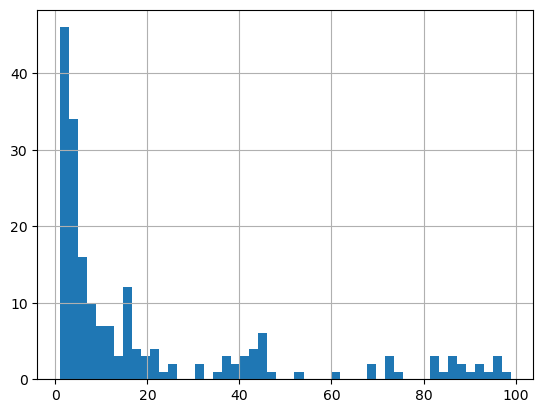

In [25]:
task_by_rxn.sum(axis=1).hist(bins=50)

# GPRs

In [26]:
rxn_list = pd.DataFrame.from_records(_gpr_records, columns=['Reaction', 'GPR'])

In [27]:
rxn_list = rxn_list.loc[~rxn_list['GPR'].isna()].set_index('Reaction').astype(str)

In [28]:
rxn_list['GPR']

Reaction
13DAMPPOX                         11754 or 76507 or 237940 or 237940
24_25VITD2Hm                                                   13081
24_25VITD3Hm                                                   13081
25VITD2Hm                                                      13115
25VITD3Hm                                                      13115
                                         ...                        
co_TRANSLOC_6      ( 53421 ) and ( 66212 ) and ( 20335 ) and ( 69...
BiP_release                    ( 81500 ) and ( 12282 ) and ( 14828 )
SP_degradation     (( 26440 ) or ( 19166 ) or ( 19167 ) or ( 2644...
PROTA_formation    ( 26440 ) and ( 19166 ) and ( 19167 ) and ( 26...
PROTB_formation    ( 19170 ) and ( 26445 ) and ( 26446 ) and ( 19...
Name: GPR, Length: 2338, dtype: object

In [29]:
rxn_list.reset_index(drop=False, inplace=True)

In [30]:
genes = scipy.io.loadmat(folder + '/parsedGPR/parsedGPR_MT_iMM1415_sec.mat')

In [31]:
genes['parsedGPR']

array([[array([[array([], dtype='<U1')]], dtype=object)],
       [array([[array([], dtype='<U1')]], dtype=object)],
       [array([[array([], dtype='<U1')]], dtype=object)],
       ...,
       [array([[array([[array(['16912'], dtype='<U5')],
                       [array(['16913'], dtype='<U5')],
                       [array(['19170'], dtype='<U5')],
                       [array(['19171'], dtype='<U5')],
                       [array(['19172'], dtype='<U5')],
                       [array(['19173'], dtype='<U5')],
                       [array(['19175'], dtype='<U5')],
                       [array(['19177'], dtype='<U5')],
                       [array(['26445'], dtype='<U5')],
                       [array(['26446'], dtype='<U5')],
                       [array(['73902'], dtype='<U5')]], dtype=object)]],
              dtype=object)                                              ],
       [array([[array([], dtype='<U1')]], dtype=object)],
       [array([[array([], dtype='<U1')]], dtyp

In [32]:
len(rxn_list['Reaction']), len(genes['parsedGPR'])

(2338, 3870)

In [33]:
genes['parsedGPR'][-4][0][0][0]

array([[array(['19166'], dtype='<U5')],
       [array(['19167'], dtype='<U5')],
       [array(['26440'], dtype='<U5')],
       [array(['26441'], dtype='<U5')],
       [array(['26442'], dtype='<U5')],
       [array(['26444'], dtype='<U5')],
       [array(['73677'], dtype='<U5')]], dtype=object)

In [34]:
gene_names = set()
for idx, row in rxn_list.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR']
    if isinstance(gpr, str):
        elements = re.findall(r'\b[\w:]+\b', gpr)
        _genes = [e for e in elements if e not in ('and', 'or', 'AND', 'OR')]
        for g in _genes:
            if 'HGNC:' not in g:
                gene_names.add(str(g))

In [35]:
len(gene_names)

1565

In [36]:
'18126' in gene_names

True

### Grab new genes from secCellFie

In [37]:
import mygene

In [38]:
mg = mygene.MyGeneInfo()

In [39]:
geneid_df = mg.getgenes(gene_names, fields='entrezgene,symbol,name,alias,taxid,HGNC', as_dataframe=True, 
                        species='10090')

In [40]:
geneid_df = geneid_df.reset_index().drop(columns=['_id', '_version'])

In [41]:
geneid_df[~geneid_df['notfound'].isna()].shape

(41, 7)

In [42]:
geneid_df[~geneid_df['notfound'].isna()]['query'].values.tolist()

['4844',
 '91734',
 '9952',
 '26062',
 '514',
 '8908',
 '7359',
 '169124',
 '4710',
 '284208',
 '4122',
 '26237',
 '2713',
 '286016',
 '9954',
 '286297',
 '4707',
 '4845',
 '2544',
 '5334',
 '6537',
 '285216',
 '222',
 '10476',
 '79087',
 '6487',
 '55350',
 '8781',
 '4541',
 '2679',
 '2655',
 '160287',
 '23563',
 '1159',
 '54480',
 '348477',
 '27124',
 '80068',
 '5240',
 '280',
 '2974']

In [43]:
manual_ids = {

 '10476' : 'Atp5pd',
 '5334' : 'Plcl1',
 '285216' : 'Mthfd2', # Not 100% sure
# '169124', # Not found
 '8908' : 'Gyg1', # It should be 'Gyg2' but mus musculus does not have it
 '26237' : 'Eno1b',
 '54480' : 'Chpf2',
# '6537', # Not found
 '4845' : 'Nos2', # It should be 'Nos2C', but not in mus musculus
 '6487' : 'St3gal3',
 '9952' : 'Hs3st2', # It should be 'Hs3st3', but not in mus musculus
 '4122' : 'Man2a2',
 '514' : 'Atp5f1e',
 '23563' : 'Chst5',
 '4707' : 'Ndufb1',
 '4844' : 'Nos2', # It should be 'Nos2B', but not in mus musculus
 '348477' : 'Mia3',
 '286297' : 'Mthfd2', # Not 100% sure
 '9954' : 'Hs3st1', # It should be 'Hs3st3', but not in mus musculus
 '2713' : 'Gk',
 '284208' : 'B3gntl1',
 '91734' : 'Idi2',
 '4541' : 'mt-Nd6',
 '160287' : 'Ldha',
 '7359' : 'Ugp2',
 '222' : 'Aldh3b2',
 '4710' : 'Ndufb4',
 '27124' : 'Inpp5j',
 '80068' : 'Mthfd2l',
 '280' : 'Amy2b',
 '8781' : 'Psph',
 '2974' : 'Gucy1b2',
 '286016' : 'Tpi1',
 '55350' : 'Vnn3',
 '2679' : 'Ggt1', # Should be Ggt3, but not in mus musculus
 '1159' : 'Ckmt1',
 '100039108' : 'Gm10231',
 '2544' : 'Slc37a4',
 '79087' : 'Alg12', 
 '6537' : 'Slc6a8', 
 '2655' : 'Ggct',
 '5240' : 'Pgp',
 #'169124' : '', # Not found
 '26062' : 'Hyal6'
}

In [44]:
[g for g in geneid_df[~geneid_df['notfound'].isna()]['query'].values.tolist() if g not in manual_ids.keys()]

['169124']

In [45]:
_df = geneid_df.copy()
if 'notfound' in _df.columns:
    _df = _df[_df['notfound'].isna()]
_df['alias'] = [', '.join(a) if isinstance(a, list) else a for a in _df['alias']]

In [46]:
_df.shape

(1524, 7)

In [47]:
sec_df = _df

In [48]:
sec_df.head()

,query,alias,entrezgene,name,symbol,taxid,notfound
0,18805,"Pld1a, Pld1b, mPLD1",18805,phospholipase D1,Pld1,10090.0,NaN
1,26445,"C7-I, D4Wsu33e, HC7-I",26445,"proteasome (prosome, macropain) subunit, beta ...",Psmb2,10090.0,NaN
2,21871,"8430408C20Rik, ATP6a2, Atp6n1d, Atp6n2, ISF, J...",21871,"ATPase, H+ transporting, lysosomal V0 subunit A2",Atp6v0a2,10090.0,NaN
3,53897,"Cst, Gcst",53897,galactose-3-O-sulfotransferase 1,Gal3st1,10090.0,NaN
4,243616,"D930045G19Rik, E130202I16Rik, GAT4, Gabt4, Gat3",243616,solute carrier family 6 (neurotransmitter tran...,Slc6a11,10090.0,NaN


### Mappers

In [49]:
gene_id = sec_df[['entrezgene', 'symbol']].set_index('entrezgene').to_dict()['symbol']
gene_id.update(manual_ids)
gene_id = {str(k) : v for k, v in gene_id.items()}

In [50]:
def find_genes_gpr(gpr_rule):
    elements = re.findall(r'\b[\w:]+\b', gpr_rule)
    gene_ids = [e for e in elements if e not in ('and', 'or', 'AND', 'OR')]
    return gene_ids

In [51]:
def replace_gene_ids_in_gpr(gpr_rule, gene_id_mapping):
    # Use regular expressions to find gene IDs in the GPR rule
    elements = re.findall(r'\b[\w:]+\b', gpr_rule)
    gene_ids = [e for e in elements if e not in ('and', 'or', 'AND', 'OR')]

    # Replace gene IDs with their mapped values
    updated_gpr_rule = gpr_rule
    for gene_id in gene_ids:
        gene_id = str(gene_id)
        if gene_id in gene_id_mapping:
            updated_gpr_rule = updated_gpr_rule.replace(gene_id, gene_id_mapping[gene_id])

    return updated_gpr_rule

In [52]:
def clean_gene_names(text):
    # Remove spaces between parentheses and numbers
    text = re.sub(r'\(\s+', '(', text)
    text = re.sub(r'\s+\)', ')', text)

    # Regular expression pattern for single numbers in parentheses
    pattern = r'\((\d+)\)'

    # Replace the pattern with just the number
    cleaned_text = re.sub(pattern, r'\1', text)

    return cleaned_text

In [53]:
for idx, row in rxn_list.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR']
    if isinstance(gpr, str):
        gpr_new = clean_gene_names(gpr)
        old_ids = find_genes_gpr(gpr)
        new_ids = find_genes_gpr(gpr_new)

        assert(all([x1 == x2 for x1, x2 in zip(sorted(old_ids), sorted(new_ids))]))

In [54]:
gpr

'( 19170 ) and ( 26445 ) and ( 26446 ) and ( 19172 ) and ( 19173 ) and ( 19175 ) and ( 19177 ) and ( 16913 ) and ( 16912 ) and ( 19171 ) and ( 73902 )'

In [55]:
gpr_new

'19170 and 26445 and 26446 and 19172 and 19173 and 19175 and 19177 and 16913 and 16912 and 19171 and 73902'

In [56]:
all([x1 == x2 for x1, x2 in zip(sorted(old_ids), sorted(new_ids))])

True

In [57]:
# Convert entrez to gene symbol
records = []
for idx, row in rxn_list.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR']
    if isinstance(gpr, str):
        gpr = clean_gene_names(gpr)
            
    records.append((rxn_name, gpr))
rxn_list_updated = pd.DataFrame.from_records(records, columns=rxn_list.columns)

In [58]:
rxn_list_updated.shape

(2338, 2)

In [59]:
rxn_list_updated['GPR-symbol'] = rxn_list_updated['GPR'].apply(lambda x: replace_gene_ids_in_gpr(x, gene_id) if isinstance(x, str) else np.nan)

In [60]:
rxn_list_updated['GPR-symbol'] = rxn_list_updated['GPR-symbol'].replace(np.nan, '')

In [61]:
rxn_list_updated

,Reaction,GPR,GPR-symbol
0,13DAMPPOX,11754 or 76507 or 237940 or 237940,Aoc3 or Aoc1 or Aoc2 or Aoc2
1,24_25VITD2Hm,13081,Cyp24a1
2,24_25VITD3Hm,13081,Cyp24a1
3,25VITD2Hm,13115,Cyp27b1
4,25VITD3Hm,13115,Cyp27b1
...,...,...,...
2333,co_TRANSLOC_6,53421 and 66212 and 20335 and 69276 and 140740...,Sec61a1 and Sec61b and Sec61g and Sec62 and Se...
2334,BiP_release,81500 and 12282 and 14828,Sil1 and Hyou1 and Hspa5
2335,SP_degradation,(26440 or 19166 or 19167 or 26441 or 26442 or ...,(Psma1 or Psma2 or Psma3 or Psma4 or Psma5 or ...
2336,PROTA_formation,26440 and 19166 and 19167 and 26441 and 26442 ...,Psma1 and Psma2 and Psma3 and Psma4 and Psma5 ...


In [62]:
rxn_records = []
for idx, row in rxn_list_updated.iterrows():
    rxn_name = row['Reaction']
    gpr = row['GPR-symbol']
    if isinstance(gpr, str):
        elements = re.findall(r'\b[\w:]+\b', gpr)
        _genes = [e for e in elements if e not in ('and', 'or', 'AND', 'OR')]
        for g in _genes:
            rxn_records.append((rxn_name, g))

In [63]:
rxn_gene_df = pd.DataFrame.from_records(rxn_records, columns=['Reaction', 'Gene'])

In [64]:
rxn_gene_df.head()

,Reaction,Gene
0,13DAMPPOX,Aoc3
1,13DAMPPOX,Aoc1
2,13DAMPPOX,Aoc2
3,13DAMPPOX,Aoc2
4,24_25VITD2Hm,Cyp24a1


In [65]:
rxn_by_gene = pd.crosstab(rxn_gene_df['Reaction'], rxn_gene_df['Gene'])
rxn_by_gene[rxn_by_gene > 0] = 1
rxn_by_gene=rxn_by_gene.reindex(rxn_list['Reaction'].values, fill_value=0.0)

In [66]:
genes_to_drop = geneid_df[~geneid_df['notfound'].isna()]['query'].unique()
genes_to_drop = [g for g in genes_to_drop if g in rxn_by_gene.columns] #+ ['100039108']

rxn_by_gene.drop(columns=genes_to_drop)

Gene,667301,A4galt,A4gnt,Aacs,Aadac,Aadat,Aanat,Aass,Abat,Abca1,...,Vcp,Vmn2r37,Vnn1,Vnn3,Xdh,Xylb,Xylt1,Xylt2,mt,ps1
Reaction,,,,,,,,,,,,,,,,,,,,,
13DAMPPOX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24_25VITD2Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24_25VITD3Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25VITD2Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25VITD3Hm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
co_TRANSLOC_6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BiP_release,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SP_degradation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
rxn_by_gene = rxn_by_gene.drop(columns=genes_to_drop)

In [68]:
task_by_rxn

Reaction,10FTHFtm,1PPDCRp,2AMACHYD,2AMADPTm,2OXOADOXm,2OXOADPTm,34HPLFM,34HPPOR,3DPHBH1,3DSPHR,...,post_TRANSLOC_1,post_TRANSLOC_2,post_TRANSLOC_3A_1,post_TRANSLOC_3A_2,post_TRANSLOC_3B_1,post_TRANSLOC_3B_2,post_TRANSLOC_3B_3,retro_TRANSLOC_1,retro_TRANSLOC_2,thr_mt
Task,,,,,,,,,,,,,,,,,,,,,
(R)-3-Hydroxybutanoate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3'-Phospho-5'-adenylyl sulfate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AMP salvage from adenine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATP generation from glucose (hypoxic conditions) - glycolysis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acetoacetate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cis-vaccenic acid synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Linolenate degradation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Linolenate synthesis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
total_met_rxn = rxn_list_updated.loc[rxn_list_updated['Reaction'].isin(rxn_set)]['Reaction'].tolist()

In [70]:
len(total_met_rxn)

676

In [71]:
task_by_rxn = task_by_rxn[total_met_rxn]

In [72]:
task_by_rxn.shape

(196, 676)

In [73]:
rxn_by_gene = rxn_by_gene.loc[total_met_rxn,:]

In [74]:
rxn_by_gene.shape

(676, 1548)

In [75]:
task_by_gene = np.matmul(task_by_rxn, rxn_by_gene)
task_by_gene[task_by_gene > 0] = 1

In [76]:
task_by_gene.columns[task_by_gene.columns.str.contains('HGNC:')]

Index([], dtype='object', name='Gene')

In [77]:
task_by_gene.shape

(196, 1548)

In [78]:
final_genes = task_by_gene.loc[:,task_by_gene.sum()>0].columns.tolist()

In [79]:
final_tasks = task_by_gene.loc[task_by_gene.sum(axis=1)>0].index.tolist()

In [80]:
final_rxns = rxn_by_gene[final_genes][rxn_by_gene[final_genes].sum(axis=1)>0].index.tolist()

In [81]:
len(final_rxns)

676

In [82]:
task_by_rxn = task_by_rxn.loc[final_tasks, final_rxns]
task_by_rxn.shape

(195, 676)

In [83]:
task_by_gene = task_by_gene.loc[final_tasks, final_genes]
task_by_gene.shape

(195, 790)

In [84]:
rxn_by_gene = rxn_by_gene.loc[final_rxns, final_genes]
rxn_by_gene.shape

(676, 790)

In [85]:
rxn_list_updated = rxn_list_updated.loc[rxn_list_updated['Reaction'].isin(final_rxns)].reset_index(drop=True)

In [86]:
task_df = task_df.loc[final_tasks,:]

# Exports

In [87]:
task_df.to_csv('./mus_musculus/Task-Info.csv')

In [88]:
task_by_rxn.to_csv('./mus_musculus/Task_by_Rxn.csv')

In [89]:
rxn_by_gene.to_csv('./mus_musculus/Rxn_by_Gene.csv')

In [90]:
task_by_gene.to_csv('./mus_musculus/Task_by_Gene.csv')

In [91]:
rxn_list_updated.to_json('./mus_musculus/Rxn-Info-iMM1415.json')